In [1]:
%matplotlib inline
from HeaderP import *
import FLICKER as flc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.utils as au
from astropy.io import fits
import astropy.coordinates as coord

from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import normalize

In [39]:
# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
print('McQuillian',np.shape(McQS))

# gaia data from https://gaia-kepler.fun/
with fits.open('kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

# merge two tables with same KID
df = pd.merge(McQS, gaia, left_on="KID", right_on="kepid", how="inner")
#print(df)

# drop duplicates
df.drop_duplicates(subset ="KID", keep='first', inplace = True) 

print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]-np.shape(df)[0]))

McQuillian (34030, 11)
Cross-matched (33936, 145)
Missing 94 stars


Garcia2014 (310, 9)
Santos2019 (15640, 23)
Cross-matched Garcia2014 (304, 143)
Cross-matched Santos2019 (14962, 157)
Merged data shape: (49202, 167)
Stars added from Garcia 2014: 304
Stars added from Santos 2019: 14962
Origional KID length: 33936
Recovered KID from original: 33936
Stars Added from Garcia2014 and Santos2019: 4637


Text(0.5, 0, 'Prot')

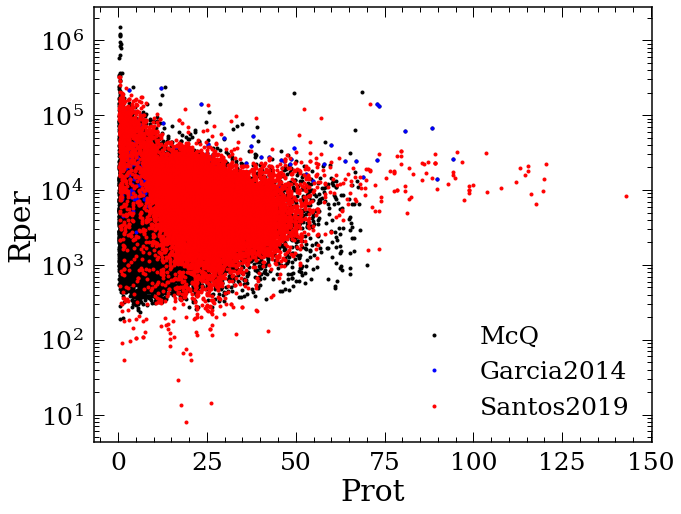

In [40]:
# read in stars from https://ui.adsabs.harvard.edu/abs/2014A%26A...572A..34G/abstract
GarsS=pd.read_csv('Garcia2014.csv')
# read in stars from https://ui.adsabs.harvard.edu/abs/2019ApJS..244...21S/abstract
SantosS=pd.read_csv('Santos2019.txt', sep=" ", header=0)
# print out the shapes
print('Garcia2014',np.shape(GarsS))
print('Santos2019',np.shape(SantosS))

df_Gars = pd.merge(GarsS, gaia, left_on="KIC", right_on="kepid", how="inner")
df_Sant = pd.merge(SantosS, gaia, left_on="KIC", right_on="kepid", how="inner")

df_Gars.rename(columns={'KIC':'KID'}, inplace=True)
df_Sant.rename(columns={'KIC':'KID'}, inplace=True)

Sph=df_Gars.Sph
Prot=df_Gars.Prot

Sph_S=df_Sant.Sph*5
Prot_S=df_Sant.Prot

df_Gars.rename(columns={'Sph':'Rper'}, inplace=True)
df_Gars.rename(columns={'e_Prot':'Prot_err'}, inplace=True)
df_Sant.Sph=df_Sant.Sph*5
df_Sant.rename(columns={'Sph':'Rper'}, inplace=True)
df_Sant.rename(columns={'e_Prot':'Prot_err'}, inplace=True)

df_Gars.drop_duplicates(subset ="KID", keep = False, inplace = True) 
df_Sant.drop_duplicates(subset ="KID", keep = False, inplace = True) 

print('Cross-matched Garcia2014',np.shape(df_Gars))
print('Cross-matched Santos2019',np.shape(df_Sant))

# merge three tables
df_Gar_Mc = pd.concat([df,df_Gars],sort="False",ignore_index=True)
df_Sant_Gar_Mc = pd.concat([df_Gar_Mc,df_Sant],sort="False",ignore_index=True)

print('Merged data shape:',np.shape(df_Sant_Gar_Mc))
print('Stars added from Garcia 2014:',np.shape(df_Gar_Mc)[0]-np.shape(df)[0])
print('Stars added from Santos 2019:',np.shape(df_Sant_Gar_Mc)[0]-np.shape(df_Gar_Mc)[0])

df_Sant_Gar_Mc.drop_duplicates(subset ="KID", keep='first', inplace = True) 


print('Origional KID length:',len(df['KID']))
print('Recovered KID from original:',np.shape(df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID'].isin(df['KID'])])[0])

print('Stars Added from Garcia2014 and Santos2019:',np.shape(df_Sant_Gar_Mc)[0]-np.shape(df)[0])

plt.figure(figsize=(10,8))
plt.semilogy(df_Gar_Mc.Prot,df_Gar_Mc.Rper,'k.',label='McQ')
plt.semilogy(Prot,Sph,'b.',label='Garcia2014')
plt.semilogy(Prot_S,Sph_S,'r.',label='Santos2019')
plt.legend()
plt.ylabel('Rper')
plt.xlabel('Prot')

#np.save('SantKID',df_Sant.KID)

In [41]:
# calculate vtan and vb
v_tan,v_b=CalcV(df_Sant_Gar_Mc)
# add v_b and v_tan into dataframe
df_Sant_Gar_Mc['v_b']=v_b
df_Sant_Gar_Mc['v_tan']=v_tan
df_Sant_Gar_Mc=df_Sant_Gar_Mc.reset_index(drop=True)

/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/equivalencies.py:90: RuntimeWarning: invalid value encountered in less
  d[d < 0] = np.nan
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/lucy/anaconda3/lib/pytho

In [42]:
TranF=np.load('TrainingFeatures.npy')
print(TranF)

['Rper' 'teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error'
 'v_b' 'radius_val' 'b']


# Read lc

In [43]:
from __future__ import print_function
import glob
import os
from tqdm import trange
def load_and_join(LC_DIR):
    """
    load and join quarters together.
    Takes a list of fits file names for a given star.
    Returns the concatenated arrays of time, flux and flux_err
    """
    fnames = sorted(glob.glob(os.path.join(LC_DIR, "*fits")))
    #print(fnames)
    hdulist = fits.open(fnames[0])
    t = hdulist[1].data
    time = t["TIME"]
    flux = t["PDCSAP_FLUX"]
    flux_err = t["PDCSAP_FLUX_ERR"]
    q = t["SAP_QUALITY"]
    m = np.isfinite(time) * np.isfinite(flux) * np.isfinite(flux_err) * \
            (q == 0)
    x = time[m]
    med = np.median(flux[m])
    y = flux[m]/med - 1
    yerr = flux_err[m]/med
    for fname in fnames[1:]:
       hdulist = fits.open(fname)
       t = hdulist[1].data
       time = t["TIME"]
       flux = t["PDCSAP_FLUX"]
       flux_err = t["PDCSAP_FLUX_ERR"]
       q = t["SAP_QUALITY"]
       m = np.isfinite(time) * np.isfinite(flux) * np.isfinite(flux_err) * \
               (q == 0)
       x = np.concatenate((x, time[m]))
       med = np.median(flux[m])
       y = np.concatenate((y, flux[m]/med - 1))
       yerr = np.concatenate((yerr, flux_err[m]/med))
    return x, y, yerr

def load_and_split(LC_DIR):
    """
    load individual quarters.
    Takes a list of fits file names for a given star.
    Returns a list of arrays of time, flux and flux_err
    """

    fnames = sorted(glob.glob(os.path.join(LC_DIR, "*fits")))
    time, flux, flux_err = [], [], []
    for i in range(len(fnames)):
        hdulist = fits.open(fnames[i])
        t = hdulist[1].data
        x, y, yerr = t["TIME"], t["PDCSAP_FLUX"], t["PDCSAP_FLUX_ERR"]
        m = np.isfinite(x) * np.isfinite(y) * np.isfinite(yerr) \
                        * (t["SAP_QUALITY"] == 0)

        time.append(x[m])
        med = np.median(y[m])
        flux.append(y[m]/med - 1)
        flux_err.append(yerr[m]/med)

    return time, flux, flux_err

# Get power spectrum

In [44]:
from scipy import signal
from astropy import units as u
############### function to pass the lc through high pass filter of 20 days and 80 days ###############
def hp_spec(t,sig,plotP=False):
    '''
    ### inputs:
    # t: Time array [days]
    # sig: Flux array
    # plotP: plot lightcurves or not
    ### outputs:
    # sig_20,sig_80: flux signal after using 20 days and 80 days high-pass filter
    '''
    # 20 days to rad/s
    hp20=20 * u.day
    hp20=hp20.to(u.second)  
    hp20=1./hp20
    #print(hp20.value*1e6,'mu Hz')

    # 80 days to rad/s
    hp80=80 * u.day
    hp80=hp80.to(u.second)  
    hp80=1./hp80
    #print(hp80.value*1e6,'mu Hz')

    # convert time to seconds
    t = (t*u.day).to(u.second).value

    # define butterfilter for 20 days
    sos_20 = signal.butter(100, hp20, 'highpass', fs=(max(t)-min(t))/len(t), output='sos')
    sig_20 = signal.sosfilt(sos_20, sig)

    # define butterfilter for 80 days
    sos_80 = signal.butter(100, hp80, 'highpass', fs=(max(t)-min(t))/len(t), output='sos')
    sig_80 = signal.sosfilt(sos_80, sig)

    """
    plt.figure(figsize=(15,4))
    plt.plot(sig_20-sig_80,'k-',label='sig_20-sig_80')
    plt.ylabel('$\Delta$Flux')
    plt.xlabel('Time [days]')
    plt.legend()
    """
    if plotP:
        plt.figure(figsize=(20,15)) 
        plt.subplot(3, 1, 1)
        t=(t*u.second).to(u.day).value
        plt.plot(t-min(t), sig,'k-',label='Original lc')
        plt.ylabel('Flux')
        plt.legend()
        plt.subplot(3, 1, 2)
        plt.plot(t-min(t), sig_20,'k-',label='20 day high-pass')
        plt.ylabel('Flux')
        plt.legend()
        plt.subplot(3, 1, 3)
        plt.plot(t-min(t), sig_80,'k-',label='80 day high-pass')
        plt.ylabel('Flux')
        plt.xlabel('Time [days]')
        plt.legend()
    return sig_20,sig_80


from astropy.timeseries import LombScargle
import astropy.units as u
def getPspec(t,sig,sig_err,plotP=False):
    '''
    ### inputs:
    # t: Time array [days]
    # sig: Flux array
    # sig_err: Flux error array
    # plotP: plot powerspectrum or not
    ### outputs:
    # np.column_stack((freqs_20,power_20)),np.column_stack((freqs_80,power_80)): powerspectrum for hp 20 and hp 80 days
    '''
    
    t_days = t
    dy = sig_err

    # lc passed by high-pass filter 20, 80 days
    sig_20,sig_80=hp_spec(t,sig)
    
    # lomb-scargle
    #### define frequency use to analyze
    nfreq=50000 # how many points in frequency space
    maxtime=max(t) # max time
    mintime=min(t) # min time

    tstep=abs(t[1]-t[0]) # timestep

    freqmax=1/tstep*0.5 # def max frequency
    freqmin_20 = 0.00001 # def min frequency for 20 day hp filter
    freqmin_80 = 0.00001 # def min frequency for 20 day hp filter
    #freqmin_20 = 1/(20.) # def min frequency for 20 day hp filter
    #freqmin_80 = 1/(80.) # def min frequency for 20 day hp filter

    freqstep_20 = (freqmax-freqmin_20)/nfreq # def frequency spacing for 20 day hp
    freqstep_80 = (freqmax-freqmin_80)/nfreq # def frequency spacing for 80 day hp

    freqs_20 = [freqmin_20+i*freqstep_20 for i in range(nfreq)] # def frequency array for 20 day hp
    freqs_80 = [freqmin_80+i*freqstep_80 for i in range(nfreq)] # def frequency array for 80 day hp

    # get the power from lombscargle (weighted from astropy)
    power_20 = LombScargle(np.asarray(t_days), np.asarray(sig_20),dy).power(np.asarray(freqs_20))
    power_80 = LombScargle(np.asarray(t_days), np.asarray(sig_80),dy).power(np.asarray(freqs_80))

    # convert frequencies to muHz
    freqs_20=np.asarray(freqs_20)*(1./u.day.to(u.second)*1e6)
    freqs_80=np.asarray(freqs_80)*(1./u.day.to(u.second)*1e6)
    if plotP:
        plt.figure(figsize=(15,8))
        plt.subplot(2,1,1)
        plt.loglog(np.asarray(freqs_20), power_20,'k-',label='PS after 20 day hp')
        plt.plot([1/(20.),1/(20.)],[0,max(power_20)],'r--',label='20 day')
        plt.xlim([0.01,300])
        plt.ylabel('20 day hp')
        plt.legend()

        plt.subplot(2,1,2)
        plt.loglog(np.asarray(freqs_80), power_80,'k-',label='PS after 80 day hp')
        plt.plot([1/(80.),1/(80.)],[0,max(power_80)],'r--',label='80 day')
        plt.xlabel('Frequency [$\mu$Hz]')
        plt.xlim([0.01,300])
        plt.ylabel('80 day hp')
        plt.legend()
    
    return np.column_stack((freqs_20,power_20)),np.column_stack((freqs_80,power_80))

# Calculate FLIPER

In [45]:
from FLIPER import *
def CalcF(star_tab_psd_20,star_tab_psd_80,kepmag):
    '''
    star_tab_psd_20=np.column_stack((freqs_20,power_20))
    star_tab_psd_80=np.column_stack((freqs_80,power_80))

    #Give star parameters
    kepmag          =   12.62
    '''
    """
    Calculate FliPer values.
    """
    Fliper_20_d =   FLIPER().Fp_20_days(star_tab_psd_20, kepmag)
    Fliper_80_d =   FLIPER().Fp_80_days(star_tab_psd_80, kepmag)
    Fp02        =   Fliper_80_d.fp02[0]
    Fp07        =   Fliper_20_d.fp07[0]
    Fp7         =   Fliper_20_d.fp7[0]
    Fp20        =   Fliper_20_d.fp20[0]
    Fp50        =   Fliper_20_d.fp50[0]
    return Fp02,Fp07,Fp7,Fp20,Fp50

# Function for Rvar, Rvar_27

In [46]:
# get Rvar from np.percentile(flux,95)-np.percentile(flux,5)
import random
def getRvar(Flux):
    return abs(np.percentile(Flux,95)-np.percentile(Flux,5))

def cut_lc(Time,Flux,Fluxerr,days): # cut out a random section of data
    #print(np.shape(Time))
    # days: how many days to cut the lightcurves into
    ####### might want to make better constrain here for what's the min point #######
    minpoints=len(Time)/(max(Time)-min(Time))*days*0.8 # min number of points to accept the cut
    startT=random.choice(Time)
    endT=startT+days
    # put these into dataframe
    data=np.array((Time,Flux,Fluxerr)).T
    columns=['Time','Flux','Flux_err']
    df=pd.DataFrame(data,columns=columns) 
    sel_df=df.loc[(df['Time']>=startT) & (df['Time']<=endT)] # get selected data
    # regenerate cut if too short
    while len(sel_df.Time)<minpoints:
        startT=random.choice(Time) # chose a random time to start
        endT=startT+days 
        sel_df=df.loc[(df['Time']>=startT) & (df['Time']<=endT)] # get selected data
    return sel_df

def getRvar_27(Time,Flux,Fluxerr,days):
    sel_df=cut_lc(Time,Flux,Fluxerr,days)
    return getRvar(sel_df.Flux)

In [47]:
def linearInt(x,y):
    """Linear interpolation between 2 points.

    Args:
      x: x values
      y: y values

    Returns:
      f: linear function returned that accepts x and return y
    """
    a=(y[1]-y[0])/(x[1]-x[0])
    b=y[0]-a*x[0]
    
    # function to return
    def f(x):
        return a*x+b
    return f


def SingleFlicker(time,flux,Time):
    """Calculate Flicker value for a single lightcurve.

    Args:
      time: time in unit of days
      flux: flux in unit of ppt
      Time: timescale to calculate flicker value, in unit of days

    Returns:
      flicker: flicker value
    """
    # squeeze into 1d array
    time=np.squeeze(time)
    flux=np.squeeze(flux)
    
    #print(np.shape(time))
    # interpolate between missing points
    flux_int=[]
    time_int=[]
        
    # calculate cadence and how many points to calcualte moving median
    #print(np.shape(time))
    #print(np.diff(time))
    timestep=np.median(np.diff(time)) # get the cadence
    points=int(round(Time/timestep)) # get how many points to do the moving median

    printn=0
    for i in range(len(flux)-1):
        intstep=round((time[i+1]-time[i])/timestep)
        if intstep>len(flux)*0.02 and printn==0: # if interpolating more than 5% of the data points...
            print('Warnings: Interpolating over 2% of the total data!')
            printn=1
        if intstep!=1: # if time is missing
            f = linearInt([time[i],time[i+1]], [flux[i],flux[i+1]])
            intstep=int(intstep)-1
            for k in range(intstep):
                flux_int.append(f(time[i]+(k+1)*timestep))
                time_int.append(time[i]+(k+1)*timestep)
        else:
            flux_int.append(flux[i])
            time_int.append(time[i])
        
    # calculate moving median
    df=pd.Series(flux_int)
    medF=df.rolling(points).median()
        
    # put in pandas to get rid of N/A's
    medF=pd.DataFrame(np.array((flux_int,medF)).T,columns=['flux','median']).dropna()

    # calculate flicker
    flicker=np.sqrt(abs(np.mean((np.power(medF['flux'],2.)-np.power(medF['median'],2.)))))
    return flicker


def Flicker(time,flux,Time=8,Kp=0):
    """Calculate Flicker value for a lightcurve.
    
    Flicker() will return a single flicker value. Input can either be a 1d array/list or a list of
    multiple lists for the times and fluxes from differnt observing quarters. Flicker() will return 
    the median flicker value from all the quarters. 

    Args:
      time: time in unit of days
      flux: flux in unit of ppt
      Time: timescale to calculate flicker value, in unit of hours (optional)
      Kp: Kepler magnitude for correction (optional)

    Returns:
      flicker: flicker value
    """
    flux=np.array(flux)
    time=np.array(time)
    
    ########################################## Sanity checks ##########################################
    # check dimension
    if flux.ndim>2:
        raise OverflowError('Input flux and time dimension must be 1 or 2!')
    ########################################## Sanity checks ##########################################
    
    # figure out if input is a list of list or an array
    try:
        row,col=np.shape(flux)
        quart=min([row,col])
        if quart>2:
            quart=2
    except ValueError:
        #print(type(flux[0]))
        if (type(flux[0]) is list) or (type(flux[0]) is np.ndarray):
            quart=3
        else:
            quart=1
        
    # calculate correction if Kp!=0
    if Kp!=0:
        logF8_c=-0.03910-0.67187*Kp+0.06839*Kp**2.-0.001755*Kp**3.
    
    # convert hours to days
    Time=Time/24
    
    if quart==1: # if 1D
        flicker=SingleFlicker(time,flux,Time)
    elif quart==2: # if 2D and are composed of lists with same number of arrays
        row,col=np.shape(flux)
        if col>row:
            time=time.T
            flux=flux.T
            row,col=np.shape(flux)
        flicker_a=np.zeros(col) # flicker array
        for j in range(col):
            time_sing=time[:,j]
            flux_sing=flux[:,j]
            if len(time_sing)==0:
                print('Warning: there is lightcurve with 0 lenghth!')
                flicker_a[j]=0
            else:
                flicker_a[j]=SingleFlicker(time_sing,flux_sing,Time)
        flicker=np.median(flicker_a)
    else: # if 2d and is composed of uneven list
        flicker_a=np.zeros(len(flux)) # flicker array

        for j in range(len(flux)):
            time_sing=time[j]
            flux_sing=flux[j]
            if len(time_sing)==0:
                print('Warning: there is lightcurve with 0 lenghth!')
                flicker_a[j]=0
            else:
                flicker_a[j]=SingleFlicker(time_sing,flux_sing,Time)
        flicker=np.median(flicker_a)
    
    # if no magnitude, return only flicker value, else return corrected flicker value as well
    if Kp==0:
        return flicker
    else:
        return flicker,np.sqrt((flicker)**2-(np.power(10.,logF8_c))**2)

In [48]:
import random
import pandas as pd
def cut_lc(Time,Flux,Fluxerr,days): # cut out a random section of data
    #print(np.shape(Time))
    # days: how many days to cut the lightcurves into
    ####### might want to make better constrain here for what's the min point #######
    minpoints=len(Time)/(max(Time)-min(Time))*days*0.9 # min number of points to accept the cut
    startT=random.choice(Time)
    endT=startT+days
    # put these into dataframe
    data=np.array((Time,Flux,Fluxerr)).T
    columns=['Time','Flux','Flux_err']
    df=pd.DataFrame(data,columns=columns) 
    sel_df=df.loc[(df['Time']>=startT) & (df['Time']<=endT)] # get selected data
    # regenerate cut if too short
    while len(sel_df.Time)<minpoints:
        startT=random.choice(Time) # chose a random time to start
        endT=startT+days 
        sel_df=df.loc[(df['Time']>=startT) & (df['Time']<=endT)] # get selected data
    time=sel_df.Time.values
    flux=sel_df.Flux.values
    fluxerr=sel_df.Flux_err.values
    return time,flux,fluxerr

# Rper/Sph

In [ ]:
def getRper(time,flux,period):
    timestep=np.ceil((max(time)-min(time))/period) # get how many lcs
    times=np.ceil(float(len(time))/float(timestep)) # how many points in each
    Rvars=np.zeros(timestep)
    for i range(timestep):
        Rvars[i]=getRvar(flux[i*times:(i+1)*times])

# Calculate all varibles

In [58]:
pathtolightcurves="/Volumes/LaCie/KeplerLC/data/lightcurves/"
dirc = os.listdir(pathtolightcurves)
# initialize all times/flux/flux_err
samplesize=len(dirc)

KID_sort=np.zeros(samplesize)

fp02=np.zeros(samplesize)
fp07=np.zeros(samplesize)
fp7=np.zeros(samplesize)
fp20=np.zeros(samplesize)
fp50=np.zeros(samplesize)

flicker=np.zeros(samplesize)

Rvar=np.zeros(samplesize)
Rvar_27=np.zeros(samplesize)

In [55]:
for i in range(samplesize):
    update_progress(i / samplesize)
    KID_sort[i]=dirc[i]
    LC_DIR=pathtolightcurves+dirc[i]
    # get joint lc
    time, flux, flux_err=load_and_join(LC_DIR)
    # get power spectrum
    star_tab_psd_20,star_tab_psd_80=getPspec(time,flux,flux_err)
    # get kepmag
    kepmag=df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID']==KID_sort[i]].kepmag.values
    # get flipers
    fp02[i],fp07[i],fp7[i],fp20[i],fp50[i]=CalcF(star_tab_psd_20,star_tab_psd_80,kepmag)
    # get Rvar
    Rvar[i]=getRvar(flux)
    # get Rvar_27
    Rvar_27[i]=getRvar_27(time,flux,flux_err,27.)
    
    # get seperated lc
    time_s, flux_s, flux_err_s=load_and_split(LC_DIR)
    # get flicker
    flicker[i]=Flicker(time_s,flux_s)

Progress: [####################] 100.0%
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!
Warnings: Interpolating over 2% of the total data!


NameError: name 'KID_sort_paper' is not defined

## Calculate for 27 days

In [29]:
pathtolightcurves="/Volumes/LaCie/KeplerLC/data/lightcurves/"
dirc = os.listdir(pathtolightcurves)
# initialize all times/flux/flux_err
samplesize=len(dirc)

KID_sort=np.zeros(samplesize)

fp02_27=np.zeros(samplesize)
fp07_27=np.zeros(samplesize)
fp7_27=np.zeros(samplesize)
fp20_27=np.zeros(samplesize)
fp50_27=np.zeros(samplesize)

flicker_27=np.zeros(samplesize)

Rvar_27=np.zeros(samplesize)

In [16]:
for i in range(samplesize):
    update_progress(i / samplesize)
    KID_sort[i]=dirc[i]
    LC_DIR=pathtolightcurves+dirc[i]
    # get joint lc
    time_w, flux_w, flux_err_w=load_and_join(LC_DIR)
    # cut lc for 27 days
    time, flux, flux_err=cut_lc(time_w,flux_w,flux_err_w,27.)
    # get power spectrum
    star_tab_psd_20,star_tab_psd_80=getPspec(time,flux,flux_err)
    # get kepmag
    kepmag=df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID']==KID_sort[i]].kepmag.values
    # get flipers
    fp02_27[i],fp07_27[i],fp7_27[i],fp20_27[i],fp50_27[i]=CalcF(star_tab_psd_20,star_tab_psd_80,kepmag)
    # get Rvar_27
    Rvar_27[i]=getRvar(flux)
    # get flicker
    flicker_27[i]=Flicker(time,flux)

Progress: [####################] 100.0%
Warnings: Interpolating over 2% of the total data!


In [36]:
# to make sure the lightcurve cutting tool is working...
LC_DIR="/Volumes/LaCie/KeplerLC/data/lightcurves/000892834"
time_w, flux_w, flux_err_w=load_and_join(LC_DIR)
time, flux, flux_err=cut_lc(time_w,flux_w,flux_err_w,27.)
print('old lc length',max(time_w)-min(time_w))
print('new lc length',max(time)-min(time))

old lc length 1459.4887952214267
new lc length 26.992287133602076


# Get dataframe for training

In [17]:
import os
pathtolightcurves="/Volumes/LaCie/KeplerLC/data/lightcurves/"
dirc = os.listdir(pathtolightcurves)
# initialize all times/flux/flux_err
KID_sort=[int(i) for i in dirc]
# sort KID in increasing order
KID_sort_s,index=zip(*sorted(zip(KID_sort,range(len(KID_sort)))))
if max(np.diff(index))==1:
    print("KID already in order!")
else:
    print("Need to resort KID!")

KID already in order!


In [79]:
df_New=df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID'].isin(KID_sort)].sort_values(by=['KID']).reset_index(drop=True)

df_New['Fp02']=fp02
df_New['Fp07']=fp07
df_New['Fp7']=fp7
df_New['Fp20']=fp20
df_New['Fp50']=fp50

df_New['Flicker']=flicker

df_New['Rvar']=Rvar
df_New['Rvar_27']=Rvar_27

## For 27 days

In [19]:
df_New_27=df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID'].isin(KID_sort)].sort_values(by=['KID']).reset_index(drop=True)

df_New_27['fp02_27']=fp02_27
df_New_27['Fp07_27']=fp07_27
df_New_27['Fp7_27']=fp7_27
df_New_27['Fp20_27']=fp20_27
df_New_27['Fp50_27']=fp50_27

df_New_27['Flicker_27']=flicker_27

df_New_27['Rvar_27']=Rvar_27

#df_New_27.to_pickle('LightCurveProc_27')

# Get training features

In [4]:
TranF=np.load('TrainingFeatures.npy')
TranF_n=np.append(TranF,['Fp02','Fp07','Fp7','Fp20','Fp50','Flicker','Rvar','Rvar_27','Prot'])
print(TranF_n)

['Rper' 'teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error'
 'v_b' 'radius_val' 'b' 'Fp02' 'Fp07' 'Fp7' 'Fp20' 'Fp50' 'Flicker' 'Rvar'
 'Rvar_27']


In [41]:
df_train=df_New[TranF_n]
df_train.to_pickle('LightCurveProc')

NameError: name 'df_New' is not defined

# Train

In [12]:
df_train = pd.read_pickle('LightCurveProc_27')
#df_train = pd.read_pickle('LightCurveProc')
df_train

,CP/CB_candidate_flag,DC,E_M,E_Teff,E_logg,FQ,Flag,FliPer_Class,GAIA_inary_flag,GAIA_subgiant_flag,...,w,v_b,v_tan,fp02_27,Fp07_27,Fp7_27,Fp20_27,Fp50_27,Flicker_27,Rvar_27
0,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,0.7242,-0.966857,16.909004,-333.789741,-333.789741,-333.789741,-333.789741,-333.789741,0.000123,0.013242
1,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,0.5809,-8.869635,10.262407,-228.218837,-228.218837,-228.218837,-228.218837,-228.218837,0.000148,0.010393
2,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,0.5252,-47.684635,48.426129,-349.602381,-349.602381,-349.602381,-349.602381,-349.602381,0.000490,0.003902
3,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,0.7229,2.149538,11.256302,-422.288844,-422.288844,-422.288844,-422.288844,-422.288844,0.000855,0.013387
4,-999.0,NaN,0.085,151.0,0.066,17.0,NaN,0.0,0.0,0.0,...,NaN,-2.058561,31.252457,-244.806858,-244.806858,-244.806858,-244.806858,-244.806858,0.000448,0.001933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,0.2649,-31.927968,43.368157,-649.744288,-649.744288,-649.744288,-649.744288,-649.744288,0.000603,0.002671
9995,-999.0,NaN,0.030,74.0,0.054,17.0,NaN,0.0,-999.0,-999.0,...,NaN,-53.445744,74.847292,-106.598652,-106.598652,-106.598652,-106.598652,-106.598652,0.000255,0.010546
9996,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,0.5621,-11.664362,21.623775,-407.691738,-407.691738,-407.691738,-407.691738,-407.691738,0.000442,0.007434
9997,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,0.3544,NaN,NaN,-300.980420,-300.980420,-300.980420,-300.980420,-300.980420,0.000377,0.001673


# Train on everything

In [3]:
RvarTF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Fp02','Fp07','Fp7','Fp20','Fp50','Flicker','Rvar','Rvar_27']
regr,importance,actrualF,trainKID,testKID,predictp,avstedv=my_randF_SL(df_train,0.8,RvarTF)

regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 16
Features used to train: ['teff', 'bp_g', 'lum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Fp02', 'Fp07', 'Fp7', 'Fp20', 'Fp50', 'Flicker', 'Rvar', 'Rvar_27']
9999 stars in dataframe!
Missing features: ['lum_val', 'radius_val']
Missing 288 stars from null values in data!

9711 total stars used for RF!
7768 training stars!
Finished training! Making predictions!
Finished predicting! Calculating chi^2!
Median Relative Error is: 0.21805854262267624
Finished!


average chisq is:  957.8173533882857


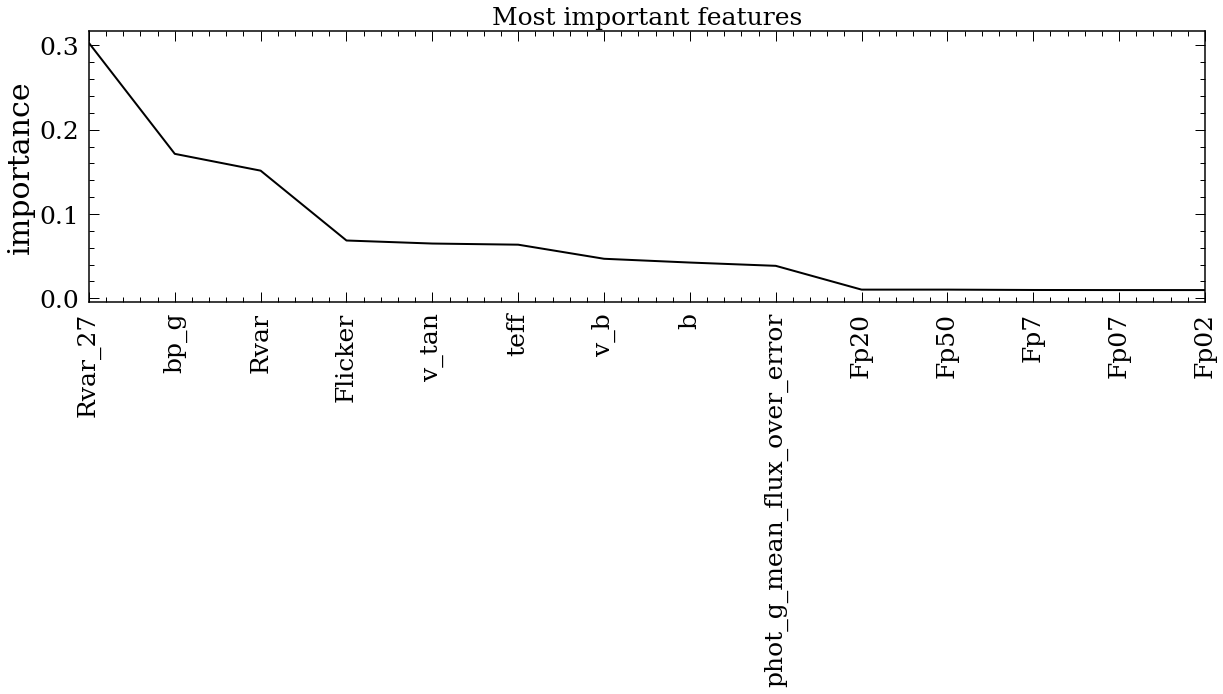

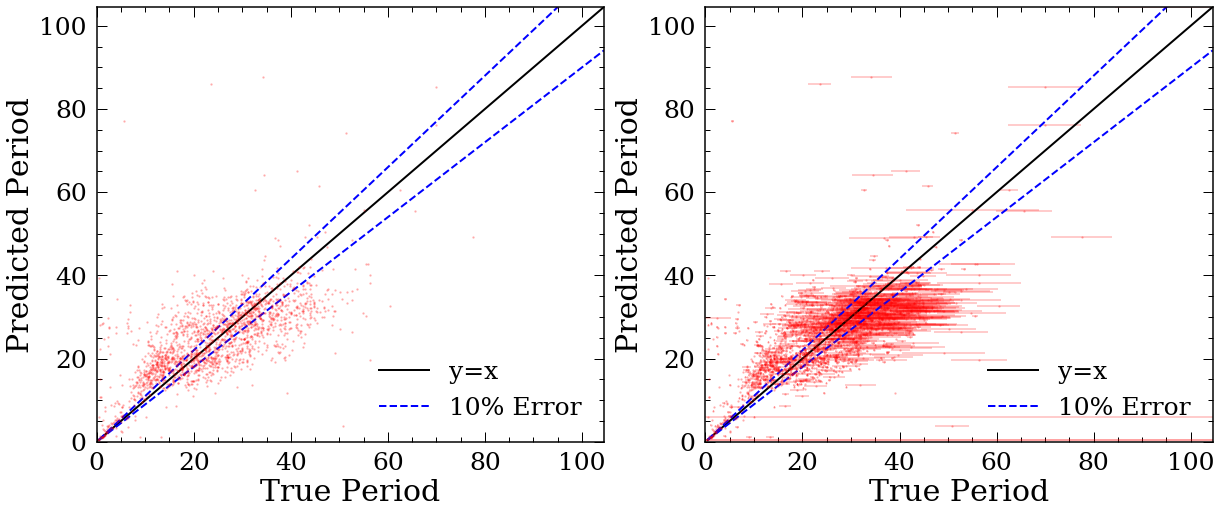

In [6]:
my_xticks=plot_result(actrualF,importance,predictp,df_train.loc[df_train['KID'].isin(testKID)].Prot.values,df_train.loc[df_train['KID'].isin(testKID)].Prot_err.values)

## For 27 days

In [13]:
RvarTF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Fp02_27','Fp07_27','Fp7_27','Fp20_27','Fp50_27','Flicker_27','Rvar_27']
regr,importance,actrualF,trainKID,testKID,predictp,avstedv=my_randF_SL(df_train,0.8,RvarTF)

regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 15
Features used to train: ['teff', 'bp_g', 'lum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Fp02_27', 'Fp07_27', 'Fp7_27', 'Fp20_27', 'Fp50_27', 'Flicker_27', 'Rvar_27']
9999 stars in dataframe!
Missing features: ['lum_val', 'radius_val']
Missing 289 stars from null values in data!

9710 total stars used for RF!
7768 training stars!
Finished training! Making predictions!
Finished predicting! Calculating chi^2!
Median Relative Error is: 0.2202565391823425
Finished!


average chisq is:  985.411156669472


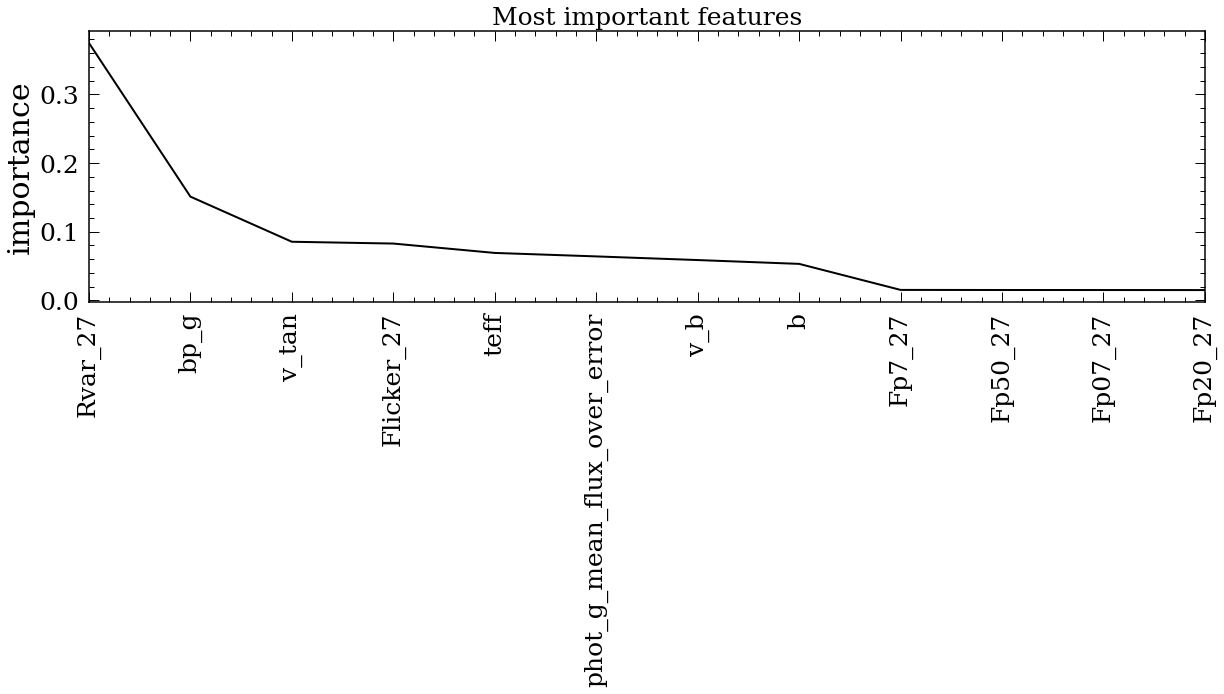

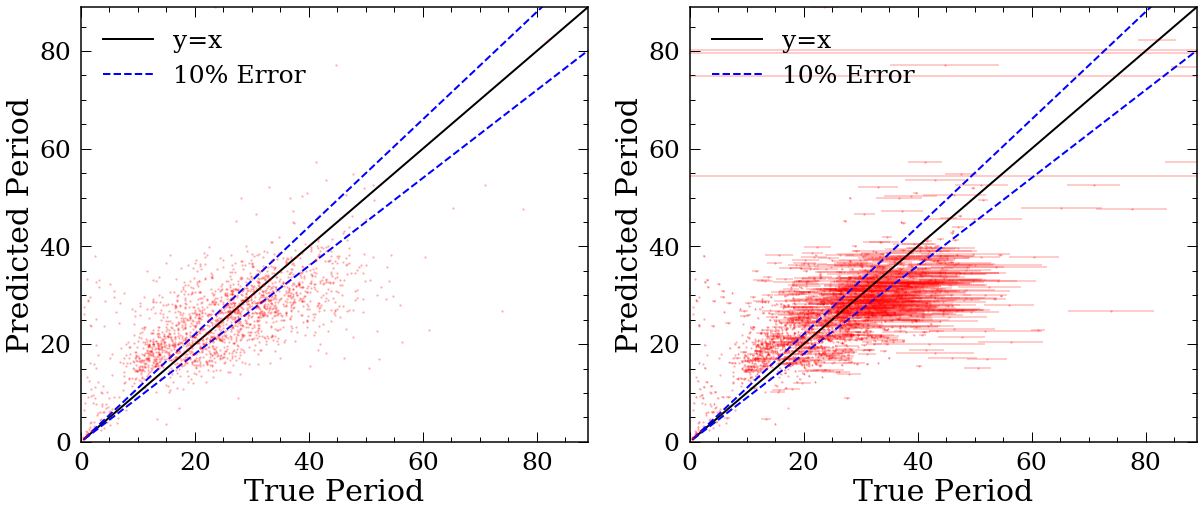

In [14]:
my_xticks=plot_result(actrualF,importance,predictp,df_train.loc[df_train['KID'].isin(testKID)].Prot.values,df_train.loc[df_train['KID'].isin(testKID)].Prot_err.values)

# Train on different things

In [15]:
def multitestTrain(df,percentT,TF,traintime):
    # df: dataframe
    # percentT: fraction of training data
    # TF: training features
    # traintime: how many times to test
    print('Feature used to train:',TF)
    Chisq_a=np.zeros(traintime)
    for i in range(traintime):
        update_progress(i / traintime)
        Chisq_a[i]=my_randF_SL(df,percentT,TF,chisq_out=1)
    return np.mean(Chisq_a),np.std(Chisq_a)

In [8]:
trantime=50
markers=['Rvar','Rvar_27','Rvar_27+FliPer','Rvar_27+Flicker','Rvar_27+FliPer/Flicker','All','Rper']
chisq_ave=np.zeros(len(markers))
chisq_std=np.zeros(len(markers))

# train on Rvar and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar']
chisq_ave[0],chisq_std[0]=multitestTrain(df_train,0.8,TF,trantime)

# train on Rvar_27 and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar_27']
chisq_ave[1],chisq_std[1]=multitestTrain(df_train,0.8,TF,trantime)

# train on Rvar_27+FliPers and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar_27','Fp07','Fp7','Fp20','Fp50']
chisq_ave[2],chisq_std[2]=multitestTrain(df_train,0.8,TF,trantime)

# train on Rvar_27+Flickers and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar_27','Flicker']
chisq_ave[3],chisq_std[3]=multitestTrain(df_train,0.8,TF,trantime)

# train on Rvar_27+FliPers/Flickers and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar_27','Fp07','Fp7','Fp20','Fp50','Flicker']
chisq_ave[4],chisq_std[4]=multitestTrain(df_train,0.8,TF,trantime)

# train on all
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Fp02','Fp07','Fp7','Fp20','Fp50','Flicker','Rvar','Rvar_27']
chisq_ave[5],chisq_std[5]=multitestTrain(df_train,0.8,TF,trantime)

# train on Rper (might need to recalculate...)
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rper']
chisq_ave[6],chisq_std[6]=multitestTrain(df_train,0.8,TF,trantime)

Progress: [####################] 98.0%
regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 9
Features used to train: ['teff', 'bp_g', 'lum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Rper']
9999 stars in dataframe!
Missing features: ['lum_val', 'radius_val']
Missing 284 stars from null values in data!

9715 total stars used for RF!
7772 training stars!
Finished training! Making predictions!
Finished predicting! Calculating chi^2!
Median Relative Error is: 0.22339583178684674
Finished!


chisq_ave [21.90775725 22.46060713 22.1952524  21.71740839 21.37119408 20.56282636
 22.68273372]
chisq_std [0.49621677 0.46552781 0.5812034  0.50283759 0.53837283 0.44775107
 0.6400697 ]


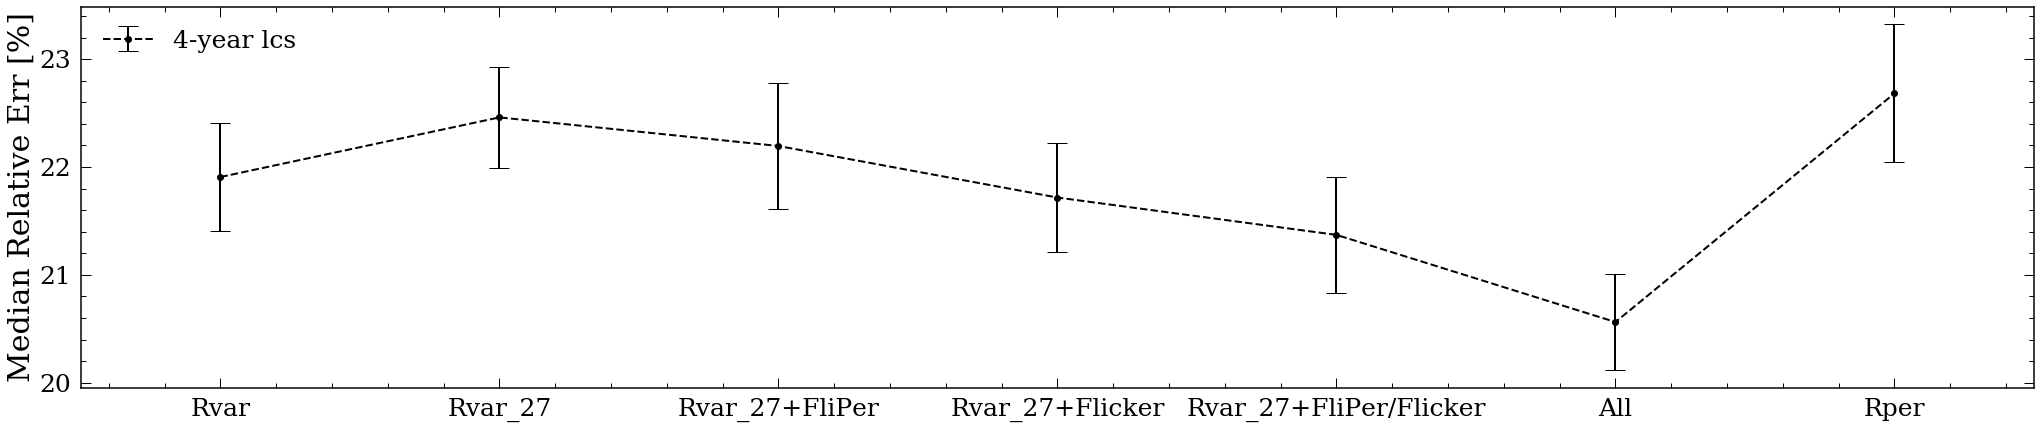

In [11]:
plt.figure(figsize=(len(markers)*5,7))
print('chisq_ave',chisq_ave*100)
print('chisq_std',chisq_std*100)
plt.errorbar(range(len(markers)),chisq_ave*100,yerr=chisq_std*100,fmt='k--o',barsabove=True,capsize=10,label='4-year lcs')
#chisq_27=[1228.56251117,1151.86547747,987.66677505,952.95935577]
#chisq_27_std=[203.30641855,174.6010212,160.48701395,166.09892241]
#plt.errorbar([1,2,3,4],chisq_27,yerr=chisq_27_std,fmt='r--o',barsabove=True,capsize=10,label='27-day lcs')
plt.xticks(range(len(markers)), markers)
plt.xlim([-0.5,len(markers)-0.5])
plt.ylabel('Median Relative Err [%]')
plt.legend()

## 27 days

In [23]:
def multitestTrain(df,percentT,TF,traintime):
    # df: dataframe
    # percentT: fraction of training data
    # TF: training features
    # traintime: how many times to test
    print('Feature used to train:',TF)
    Chisq_a=np.zeros(traintime)
    for i in range(traintime):
        update_progress(i / traintime)
        Chisq_a[i]=my_randF_SL(df,percentT,TF,chisq_out=1)
    return np.mean(Chisq_a),np.std(Chisq_a)

In [16]:
trantime=50
markers=['Rvar_27','Rvar_27+FliPer','Rvar_27+Flicker','Rvar_27+FliPer/Flicker','All']
chisq_ave=np.zeros(len(markers))
chisq_std=np.zeros(len(markers))

# train on Rvar_27 and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar_27']
chisq_ave[0],chisq_std[0]=multitestTrain(df_train,0.8,TF,trantime)

# train on Rvar_27+FliPers and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar_27','Fp07_27','Fp7_27','Fp20_27','Fp50_27']
chisq_ave[1],chisq_std[1]=multitestTrain(df_train,0.8,TF,trantime)

# train on Rvar_27+Flickers and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar_27','Flicker_27']
chisq_ave[2],chisq_std[2]=multitestTrain(df_train,0.8,TF,trantime)

# train on Rvar_27+FliPers/Flickers and not other added features
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Rvar_27','Fp07_27','Fp7_27','Fp20_27','Fp50_27','Flicker_27']
chisq_ave[3],chisq_std[3]=multitestTrain(df_train,0.8,TF,trantime)

# train on all
TF=['teff','bp_g','lum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b','Fp02_27','Fp07_27','Fp7_27','Fp20_27','Fp50_27','Flicker_27','Rvar_27']
chisq_ave[4],chisq_std[4]=multitestTrain(df_train,0.8,TF,trantime)


Progress: [####################] 98.0%
regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 15
Features used to train: ['teff', 'bp_g', 'lum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Fp02_27', 'Fp07_27', 'Fp7_27', 'Fp20_27', 'Fp50_27', 'Flicker_27', 'Rvar_27']
9999 stars in dataframe!
Missing features: ['lum_val', 'radius_val']
Missing 289 stars from null values in data!

9710 total stars used for RF!
7768 training stars!
Finished training! Making predictions!
Finished predicting! Calculating chi^2!
Median Relative Error is: 0.2154075050188495
Finished!


chisq_ave [22.41897412 22.14864711 22.13777418 21.89129264 21.93188165]
chisq_std [0.53292673 0.50966793 0.5041719  0.44645977 0.52469118]


Text(0, 0.5, 'Median Relative Err [%]')

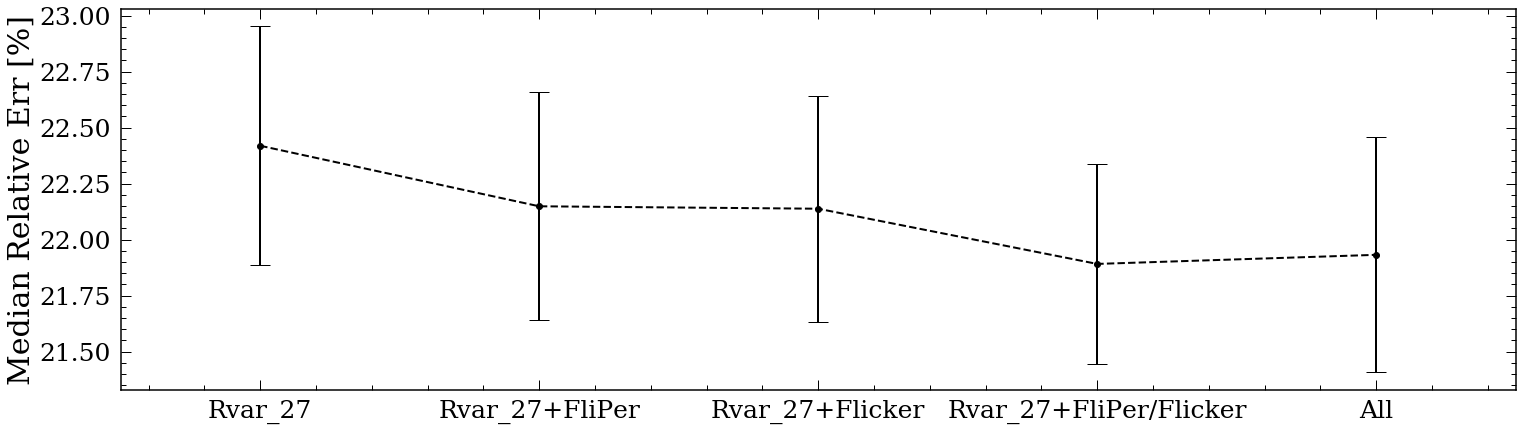

In [20]:
plt.figure(figsize=(len(markers)*5,7))
print('chisq_ave',chisq_ave*100)
print('chisq_std',chisq_std*100)
plt.errorbar(range(len(markers)),chisq_ave*100,yerr=chisq_std*100,fmt='k--o',barsabove=True,capsize=10)
plt.xticks(range(len(markers)), markers)
plt.xlim([-0.5,len(markers)-0.5])
#plt.ylim([600,1600])
plt.ylabel('Median Relative Err [%]')

#### plot results

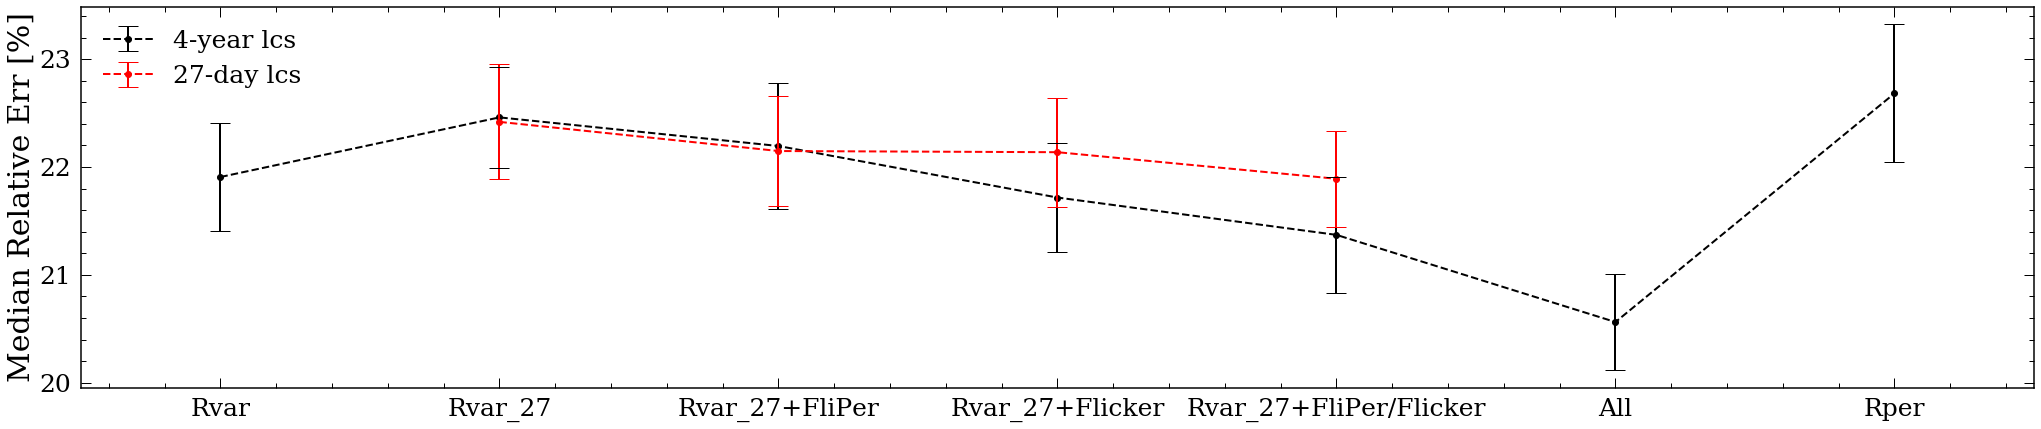

In [24]:
MRE_4year=[21.90775725,22.46060713,22.1952524,21.71740839,21.37119408,20.56282636,22.68273372]
MRE_err_4year=[0.49621677,0.46552781,0.5812034,0.50283759,0.53837283,0.44775107,0.6400697]
markers_4year=['Rvar','Rvar_27','Rvar_27+FliPer','Rvar_27+Flicker','Rvar_27+FliPer/Flicker','All','Rper']

MRE_27days=[22.41897412,22.14864711,22.13777418,21.89129264]
MRE_err_27days=[0.53292673,0.50966793,0.5041719,0.44645977]
markers_27=['Rvar_27','Rvar_27+FliPer','Rvar_27+Flicker','Rvar_27+FliPer/Flicker']

plt.figure(figsize=(len(markers_4year)*5,7))
plt.errorbar(range(len(markers_4year)),MRE_4year,yerr=MRE_err_4year,fmt='k--o',barsabove=True,capsize=10,label='4-year lcs')
plt.errorbar([1,2,3,4],MRE_27days,yerr=MRE_err_27days,fmt='r--o',barsabove=True,capsize=10,label='27-day lcs')
plt.xticks(range(len(markers_4year)), markers_4year)
plt.xlim([-0.5,len(markers_4year)-0.5])
plt.ylabel('Median Relative Err [%]')
plt.legend()
